# IMPORTING NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
data2 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
data3 = pd.read_json('Sarcasm_Headlines_Dataset (1).json', lines=True)

data = pd.concat([data1, data2, data3], ignore_index = True)

# Preview the dataset
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# DATA CLEANING AND PRE-PROCESSING

In [ ]:
# Check for missing values
data.isnull().sum()

# Remove duplicates if any
data.drop_duplicates(subset=['headline'], inplace=True)

# Split into features and labels
X = data['headline'].values
y = data['is_sarcastic'].values

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences
maxlen = 100  # maximum length of a sequence
X_padded = pad_sequences(sequences, maxlen=maxlen)

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# GloVe Embedding Model

In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

!wget http://nlp.stanford.edu/data/glove.6B.zip # Download GloVe embeddings
!unzip glove.6B.zip # Unzip the file

glove_file = 'glove.6B.100d.txt' # Set the correct path to the GloVe file
embeddings_index = load_glove_embeddings(glove_file)

--2024-10-03 20:09:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-03 20:09:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-03 20:09:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Create embedding matrix
embedding_dim = 100  # GloVe embedding dimensions
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#build the model
from tensorflow.keras.initializers import Constant

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, maxlen))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       3,088,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,214,261 (12.26 MB)

 Trainable params: 125,761 (491.25 KB)

 Non-trainable params: 3,088,500 (11.78 MB)

# TRAINING THE MODEL

In [ ]:
#model training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 139s 455ms/step - accuracy: 0.6695 - loss: 0.5986 - val_accuracy: 0.8051 - val_loss: 0.4192
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 132s 462ms/step - accuracy: 0.8129 - loss: 0.4209 - val_accuracy: 0.7963 - val_loss: 0.4391
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 130s 419ms/step - accuracy: 0.8458 - loss: 0.3602 - val_accuracy: 0.8294 - val_loss: 0.3812
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 146s 434ms/step - accuracy: 0.8675 - loss: 0.3170 - val_accuracy: 0.8424 - val_loss: 0.3709
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 139s 424ms/step - accuracy: 0.8874 - loss: 0.2821 - val_accuracy: 0.8566 - val_loss: 0.3297
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 160s 489ms/step - accuracy: 0.8978 - loss: 0.2584 - val_accuracy: 0.8621 - val_loss: 0.3361
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 122s 427ms/step - accuracy: 0.9094 - loss: 0.2309 - val_accuracy: 0.8660 - val_loss: 0.3253
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 158s 483ms/step - accuracy: 0.9174 -

# EVALUATING THE MODEL

179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.8629 - loss: 0.3853
Test Accuracy: 0.8570426106452942


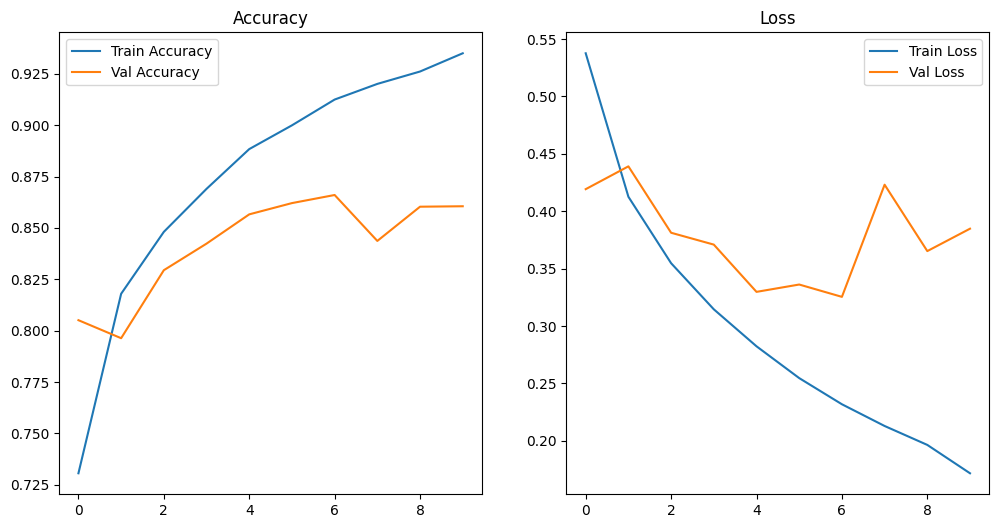

In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

# MODEL DIAGNOSTICS

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

# Compare with actual labels

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step
[[2649  342]
 [ 473 2237]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2991
           1       0.87      0.83      0.85      2710

    accuracy                           0.86      5701
   macro avg       0.86      0.86      0.86      5701
weighted avg       0.86      0.86      0.86      5701



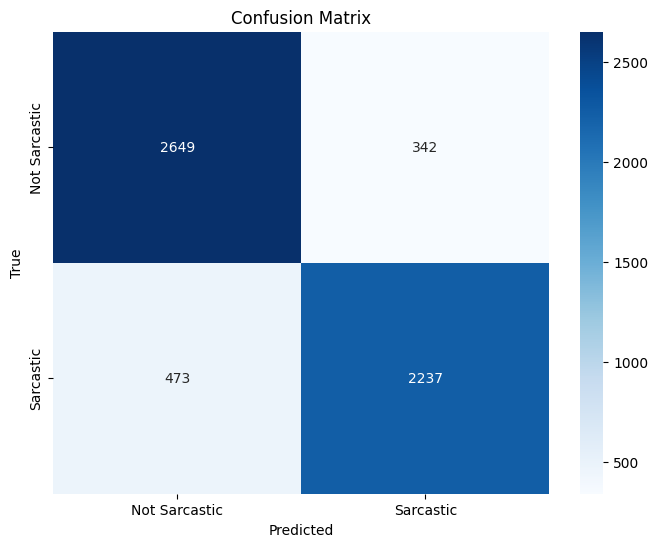

In [ ]:
# prompt: visualize ethe confusion matrix

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# MAKING PREDICTIONS

In [ ]:
#define prediction function
def predict_sarcasm(sentence, model, tokenizer, maxlen):
    # Preprocess the sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)

    # Make prediction
    prediction = model.predict(padded_sequence)

    # Interpret the prediction
    if prediction > 0.5:
        return "Sarcastic"
    else:
        return "Not Sarcastic"

In [ ]:
# Example usage
test_sentence_1 = "Breaking News: Sun Expected to Rise Again Tomorrow"
test_sentence_2 = "I absolutely love waiting in long lines."
test_sentence_3 = "It's ok if you don't like me. Not everyone has good taste."
test_sentence_4 = "Groundbreaking Research Reveals Water is Wet"
test_sentence_5 = "Study Finds That Reading More Books Makes You Smarter, Shocking Absolutely No One"
test_sentence_6 = "Local Man Shocked to Discover That Doing Nothing All Day Yields No Results"
test_sentence_7 = "Study Finds That Staring at Phone All Day is Not Great for Your Eyes"
test_sentence_8 = "Shocking Study Reveals That Exercise Actually Requires Effort"
test_sentence_9 = "Local Man Eats Entire Pizza by Himself, Earns Medal for Heroism"
test_sentence_10 = "Great job on breaking the TV. We really needed that."
test_sentence_11 = "Scientists Discover That Fire is Hot"
test_sentence_12 = "Researchers Announce That Daylight Happens During the Day"
test_sentence_13 = "New Study Reveals That Drinking Water Can Help Hydration"
test_sentence_14 = "Fantastic! Just what I needed, another spilled drink on my keyboard."
test_sentence_15 = "I admire your creativity and innovative thinking."
test_sentence_16 = "You always bring a positive attitude to the team."
test_sentence_17 = "I appreciate how you always listen and understand."
test_sentence_18 = "I love the way you dance."


print(f"Sentence: {test_sentence_1}")
print(f"Prediction: {predict_sarcasm(test_sentence_1, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_2}")
print(f"Prediction: {predict_sarcasm(test_sentence_2, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_3}")
print(f"Prediction: {predict_sarcasm(test_sentence_3, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_4}")
print(f"Prediction: {predict_sarcasm(test_sentence_4, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_5}")
print(f"Prediction: {predict_sarcasm(test_sentence_5, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_6}")
print(f"Prediction: {predict_sarcasm(test_sentence_6, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_7}")
print(f"Prediction: {predict_sarcasm(test_sentence_7, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_8}")
print(f"Prediction: {predict_sarcasm(test_sentence_8, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_9}")
print(f"Prediction: {predict_sarcasm(test_sentence_9, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_10}")
print(f"Prediction: {predict_sarcasm(test_sentence_10, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_11}")
print(f"Prediction: {predict_sarcasm(test_sentence_11, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_12}")
print(f"Prediction: {predict_sarcasm(test_sentence_12, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_13}")
print(f"Prediction: {predict_sarcasm(test_sentence_13, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_14}")
print(f"Prediction: {predict_sarcasm(test_sentence_14, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_15}")
print(f"Prediction: {predict_sarcasm(test_sentence_15, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_16}")
print(f"Prediction: {predict_sarcasm(test_sentence_16, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_17}")
print(f"Prediction: {predict_sarcasm(test_sentence_17, model, tokenizer, maxlen)}")

print(f"Sentence: {test_sentence_18}")
print(f"Prediction: {predict_sarcasm(test_sentence_18, model, tokenizer, maxlen)}")


Sentence: Breaking News: Sun Expected to Rise Again Tomorrow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Prediction: Sarcastic
Sentence: I absolutely love waiting in long lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Prediction: Not Sarcastic
Sentence: It's ok if you don't like me. Not everyone has good taste.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Prediction: Not Sarcastic
Sentence: Groundbreaking Research Reveals Water is Wet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Prediction: Not Sarcastic
Sentence: Study Finds That Reading More Books Makes You Smarter, Shocking Absolutely No One
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Prediction: Sarcastic
Sentence: Local Man Shocked to Discover That Doing Nothing All Day Yields No Results
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Prediction: Sarcastic
Sentence: Study Finds That Staring at Phone All Day is Not Great for Your Eyes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Prediction: Sarcastic
Sentence: Shocking Study Reveals That Exercise Actually Requires Effo